<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Libraries" data-toc-modified-id="Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Libraries</a></span></li><li><span><a href="#Build-road-network-model" data-toc-modified-id="Build-road-network-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Build road network model</a></span></li><li><span><a href="#OD-Trip-simulation" data-toc-modified-id="OD-Trip-simulation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>OD Trip simulation</a></span><ul class="toc-item"><li><span><a href="#Find-closest-road-access-points-for-centriods" data-toc-modified-id="Find-closest-road-access-points-for-centriods-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Find closest road access points for centriods</a></span></li></ul></li></ul></div>

# Libraries

In [44]:
import os
import sys
import networkx as nx
import osmnx as ox
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

import warnings; warnings.simplefilter('ignore')

pd.options.display.max_columns = None
pd.options.display.max_rows = 15

# Build road network model

In [3]:
# Specify file path of the Santiago convex hull
santiago_convexhull_path = '../../Air_pollution/02_data/santiago_pop_convex_hull.shp'

# Get graph (drive + service roads) from OSM
# define coordinate system as EPSG: 4326, WGS84 - World Geodetic System 1984, used in GPS
crs_lonlat = {'init': 'epsg:' + str(4326)}

# Read convex hull boundary file
bnd = gpd.read_file(santiago_convexhull_path).to_crs(crs_lonlat)

Simple plot of the boundary

<AxesSubplot:>

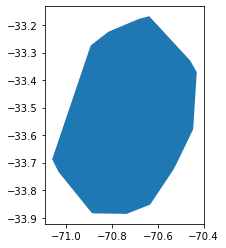

In [4]:
bnd.plot()

Extracting network from OSM database using OSMnx

In [5]:
# Create graph using OSMnx, extracting all available road networks
###
# method: osmnx.graph_from_polygon(.shp, network_type, etc.)
# ‘drive’         – get drivable public streets (but not service roads)
# ‘drive_service’ – get drivable public streets, including service roads
# ‘walk’          – get all streets and paths that pedestrians can use (this network type ignores one-way directionality)
# ‘bike’         – get all streets and paths that cyclists can use
# ‘all’          – download all (non-private) OSM streets and paths
# ‘all_private’  – download all OSM streets and paths, including private-access ones
###
G = ox.graph_from_polygon(bnd.geometry[0], network_type='all_private')

In [6]:
# Save graph file as .pk
with open('../../Air_pollution/02_data/santiago_osmnx_all_private_graph.pk', 'wb') as handle:
    pickle.dump(G, handle, protocol=2)

In [8]:
# Save as shapefile
G_shp_out_dir = '../../Air_pollution/02_data/'
ox.io.save_graph_shapefile(G, filepath=G_shp_out_dir)

# OD Trip simulation

Run the cell below to load the graph file

In [24]:
G =  pickle.load(open('../../Air_pollution/02_data/santiago_osmnx_all_private_graph.pk', 'rb'))

## Find closest road access points for centriods

In [3]:
# Read in the centroids (points) of Santiago blocks as geopandas dataframe
santiago_centriods_pts_path = "../../Air_pollution/02_data/santiago_block_centroids_wgs84.shp"
santiago_centriods_pts = gpd.read_file(santiago_centriods_pts_path)
santiago_centriods_pts.head(3)

,fid_1,CUT,REGION,PROVINCIA,COMUNA,NOMBRE_DIS,CODIGO_DIS,MANZENT,ZONA_CENSA,MANZANA,TOTAL_PERS,TOTAL_HOMB,TOTAL_MUJE,PERSONAS_0,PERSONAS_6,PERSONAS_1,PERSONAS_M,PERSONAS_E,PUEBLOS_IN,TOTAL_VIV_,TOTAL_VIV1,VIV_OCUPA_,TOTAL_VIVI,CANTIDAD_H,VIV_TIPO_C,VIV_TIPO_D,VIV_TIPO_T,VIV_TIPO_P,VIV_TIPO_M,VIV_TIPO_1,VIV_TIPO_O,VIV_PARED_,VIV_PARED1,VIV_PARE_1,VIV_PARE_2,VIV_PARE_3,VIV_PARE_4,VIV_TECHO_,VIV_TECHO1,VIV_TECH_1,VIV_TECH_2,VIV_TECH_3,VIV_TECH_4,VIV_TECH_5,VIV_PISO_P,VIV_PISO_R,VIV_PISO_B,VIV_PISO_C,VIV_PISO_T,VIV_MATERI,VIV_MATE_1,VIV_MATE_2,VIV_AGUA_R,VIV_AGUA_P,VIV_AGUA_C,VIV_AGUA_1,Manzana_ce,Manzana__1,Manzana__2,Manzana__3,centroid_x,centroid_y,geometry
0,1.0,13101.0,REGIÓN METROPOLITANA DE SANTIAGO,SANTIAGO,SANTIAGO,MATADERO,21.0,13101211002011,2.0,11.0,189.0,90,99,9,14,142,24,15,14,100.0,0.0,83.0,100.0,83.0,4.0,89.0,0.0,7.0,0.0,0.0,0.0,74.0,9.0,0.0,0.0,0.0,0.0,34.0,38.0,11.0,0.0,0.0,0.0,0.0,83.0,0.0,0.0,0.0,0.0,83.0,0.0,0.0,82.0,0.0,0.0,0.0,0.121693,0.126984,0.079365,0.074074,-7864610.0,-3958370.0,POINT (-70.64899 -33.47385)
1,2.0,13102.0,REGIÓN METROPOLITANA DE SANTIAGO,SANTIAGO,CERRILLOS,DIVINO MAESTRO,3.0,13102031005035,5.0,35.0,80.0,39,41,8,7,51,14,Indeterminado,5,20.0,0.0,20.0,20.0,23.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,12.0,4.0,2.0,0.0,0.0,5.0,0.0,14.0,1.0,0.0,0.0,0.0,14.0,0.0,6.0,0.0,0.0,12.0,8.0,0.0,20.0,0.0,0.0,0.0,0.187500,0.175000,999.000000,0.062500,-7874070.0,-3961680.0,POINT (-70.73397 -33.49865)
2,3.0,13102.0,REGIÓN METROPOLITANA DE SANTIAGO,SANTIAGO,CERRILLOS,DIVINO MAESTRO,3.0,13102031003007,3.0,7.0,29.0,13,16,Indeterminado,Indeterminado,17,8,0,Indeterminado,9.0,0.0,9.0,9.0,11.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.000000,0.275862,0.000000,999.000000,-7872570.0,-3961700.0,POINT (-70.72050 -33.49880)


In [4]:
# Collect useful columns: 'TOTAL_PERS', 'geometry'
santiago_centriods_pts_df = santiago_centriods_pts[['TOTAL_PERS', 'geometry']]

# Get latitude and longitude values for centroids
santiago_centriods_pts_df['centroid_lat'] = santiago_centriods_pts_df['geometry'].y
santiago_centriods_pts_df['centroid_lon'] = santiago_centriods_pts_df['geometry'].x

# Apply minmax scaler to the population column to create a sampling probability field
scaler = MinMaxScaler()
santiago_centriods_pts_df[['sample_prob_pop']] = scaler.fit_transform(santiago_centriods_pts_df[['TOTAL_PERS']])

# Add new index for all centroids
santiago_centriods_pts_df['id'] = santiago_centriods_pts_df.index
# Shift column 'id' to first position
first_column = santiago_centriods_pts_df.pop('id')
# Insert column using insert(position, column_name, first_column) function
santiago_centriods_pts_df.insert(0, 'id', first_column)

Find neartest access node and calculate the distance between the block centroid and the access node

In [ ]:
# Find closest access points in the graph/network
# and the distance (meters) between the centroids and access points
# TAKES LONG TIME TO RUN!
id_accessOSMid_distancem = []
for row in tqdm(range(santiago_centriods_pts_df.shape[0])):
    row_id = row
    # Get the lat and lon of block centroids
    centroid_lat = santiago_centriods_pts_df.loc[santiago_centriods_pts_df['id']==row_id]['centroid_lat'][row_id]
    centroid_lon = santiago_centriods_pts_df.loc[santiago_centriods_pts_df['id']==row_id]['centroid_lon'][row_id]
    
    # find nearest access point
    access_OSMid, distance_m = ox.distance.nearest_nodes(G, centroid_lon, centroid_lat, return_dist=True)
    
    # Store the node id, OSM id of access point, and distance between access node and block centroid (unit: meters)
    id_accessOSMid_distancem.append([row_id, access_OSMid, distance_m])

 90%|██████████████████████████████▋   | 42812/47402 [28:00:47<1:43:39,  1.36s/it]

In [42]:
# Create new dataframe for node id, OSM id of access point, and distance between access node and block centroid (unit: meters)
id_accessOSMid_distancem_df = pd.DataFrame(id_accessOSMid_distancem)

# Rename columns
id_accessOSMid_distancem_df

,0,1,2
0,0,9000087782,13.310517
1,1,9192187479,40.396543
2,2,1856490959,29.102015
3,3,9000087770,8.491737
4,4,1846000011,26.467173


Let's check the resulting dataframe